# Habitat Simulation with NoMaD Navigation - Notebook Version

This notebook demonstrates how to run the NoMaD policy in Habitat simulation.

In [8]:
# Import the main module
import sys


from habitat_main import HabitatSimulator, NoMaDPolicy, waypoint_to_habitat_action
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Video, display
import imageio

## Configuration

Set your paths here:

In [9]:
# Configuration
SCENE_PATH = "/home/liuxh/vln/vint_docker_env/tmpdata/data/versioned_data/habitat_test_scenes/skokloster-castle.glb"
MODEL_CONFIG = "/home/liuxh/vln/vint_docker_env/visualnav-transformer/train/config/nomad.yaml"
MODEL_WEIGHTS = "/home/liuxh/vln/vint_docker_env/visualnav-transformer/deployment/model_weights/nomad.pth"

NUM_STEPS = 200
WAYPOINT_INDEX = 2
NUM_SAMPLES = 8
CONTEXT_WARMUP = 10
DEVICE = 'cuda'

## Initialize Simulator and Policy

In [10]:
# Initialize Habitat simulator
print("Initializing Habitat simulator...")
habitat_sim = HabitatSimulator(
    scene_path=SCENE_PATH,
    enable_physics=True,
    resolution=(480, 640)
)
habitat_sim.initialize()
print("✓ Habitat simulator initialized.")

# Initialize NoMaD policy
print("Initializing NoMaD policy...")
policy = NoMaDPolicy(
    model_config_path=MODEL_CONFIG,
    model_weights_path=MODEL_WEIGHTS,
    device=DEVICE
)
print("✓ NoMaD policy initialized.")

Initializing Habitat simulator...
Renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 580.105.08
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_texture_view
    GL_ARB_framebuffer_no_attachments
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
    GL_KHR_parallel_shader_compile
    GL_NV_depth_buffer_float
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits
✓ Habitat simulat

[00:35:47:973686]:[Warning]:[Metadata] SceneDatasetAttributes.cpp(107)::addNewSceneInstanceToDataset : Dataset : 'default' : Lighting Layout Attributes 'no_lights' specified in Scene Attributes but does not exist in dataset, so creating default.
[00:35:47:973944]:[Warning]:[Scene] SemanticScene.h(331)::checkFileExists : ::loadSemanticSceneDescriptor: File `/home/liuxh/vln/vint_docker_env/tmpdata/data/versioned_data/habitat_test_scenes/skokloster-castle.scn` does not exist.  Aborting load.
[00:35:47:973972]:[Warning]:[Scene] SemanticScene.cpp(123)::loadSemanticSceneDescriptor : SSD File Naming Issue! Neither SemanticAttributes-provided name : `/home/liuxh/vln/vint_docker_env/tmpdata/data/versioned_data/habitat_test_scenes/skokloster-castle.scn` nor constructed filename : `/home/liuxh/vln/vint_docker_env/tmpdata/data/versioned_data/habitat_test_scenes/info_semantic.json` exist on disk.
[00:35:47:973989]:[Error]:[Scene] SemanticScene.cpp(139)::loadSemanticSceneDescriptor : SSD Load Failur

✓ NoMaD policy initialized.


## Run Exploration

In [21]:
import cv2
import math
# Recording containers
video_frames = []
trajectory_grid_points = []

print(f"Starting exploration for {NUM_STEPS} steps...")

# Exploration loop
for step in range(NUM_STEPS):
    # Get current observation
    rgb_img = habitat_sim.get_observation()
    
    # Add to policy context
    policy.add_observation(rgb_img)
    
    # Get agent position and update trajectory
    position = habitat_sim.get_agent_position()
    grid_loc = habitat_sim.world_to_map(position)
    trajectory_grid_points.append(grid_loc)
    
    # Predict action after enough context
    action=[]
    if step < CONTEXT_WARMUP:
        # Random exploration during warmup
        action.append(np.random.choice(["move_forward", "turn_left", "turn_right"]))
        if step % 10 == 0:
            print(f"Step {step}: Warmup - {action}")
    else:
        # Use policy to predict waypoint
        
        result = policy.predict_waypoint(
            waypoint_index=WAYPOINT_INDEX,
            num_samples=NUM_SAMPLES
        )
        
        if result is not None:
            waypoint, trajectory = result
            x ,y =waypoint
            if y<=1e-5:
                action.append("move_forward")
            else:
                theta = math.atan(x/y)
                if x>=0:
                    if theta>=0:
                        n = (theta*180)/math.pi // 10
                    else:
                        n = ((-theta*180)+90)/math.pi // 10
                    for _ in range(int(n)):
                        action.append("turn_right")
                    action.append( "move_forward")
                else:
                    if theta<=0:
                        n = (-theta*180)/math.pi // 10
                    else:
                        n= ((theta*180)+90)/math.pi // 10
                    for _ in range(int(n)):
                        action.append("turn_left")
                    action.append( "move_forward")


            if step % 10 == 0:
                print(f"Step {step}: Predicted waypoint {waypoint} -> {action}")
        else:
            action.append( "move_forward")
    
    # Execute action
    for act in action:
        habitat_sim.step(act)
    
    # Visualize
    # Draw trajectory on map
    map_frame = habitat_sim.draw_trajectory(trajectory_grid_points)
    
    # Resize and combine frames
    h_rgb, w_rgb = rgb_img.shape[:2]
    h_map, w_map = map_frame.shape[:2]
    scale = h_rgb / h_map
    new_w_map = int(w_map * scale)
    map_frame_resized = cv2.resize(map_frame, (new_w_map, h_rgb))
    
    # Stack side-by-side
    combined_frame = np.hstack((rgb_img, map_frame_resized))
    video_frames.append(combined_frame)

print("✓ Exploration completed.")

Starting exploration for 200 steps...
Step 0: Warmup - ['turn_right']
Inference time: 0.077s
Step 10: Predicted waypoint [0.3942418  0.16729546] -> ['turn_right', 'turn_right', 'turn_right', 'turn_right', 'turn_right', 'turn_right', 'move_forward']
Inference time: 0.074s
Inference time: 0.081s
Inference time: 0.073s
Inference time: 0.080s
Inference time: 0.075s
Inference time: 0.076s
Inference time: 0.074s
Inference time: 0.077s
Inference time: 0.073s
Inference time: 0.074s
Step 20: Predicted waypoint [3.2697191 0.1481905] -> ['turn_right', 'turn_right', 'turn_right', 'turn_right', 'turn_right', 'turn_right', 'turn_right', 'turn_right', 'move_forward']
Inference time: 0.083s
Inference time: 0.091s
Inference time: 0.076s
Inference time: 0.077s
Inference time: 0.075s
Inference time: 0.074s
Inference time: 0.075s
Inference time: 0.075s
Inference time: 0.074s
Inference time: 0.080s
Step 30: Predicted waypoint [3.3948643  0.47499514] -> ['turn_right', 'turn_right', 'turn_right', 'turn_right

## Save and Display Video

In [22]:
# Save video
output_path = "habitat_exploration_notebook.mp4"
print(f"Saving video to {output_path}...")
imageio.mimsave(output_path, video_frames, fps=10)
print(f"✓ Video saved to {output_path}")

# Display in notebook
display(Video(output_path, width=800))

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (997, 480) to (1008, 480) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Saving video to habitat_exploration_notebook.mp4...
✓ Video saved to habitat_exploration_notebook.mp4


## Visualize a Sample Frame

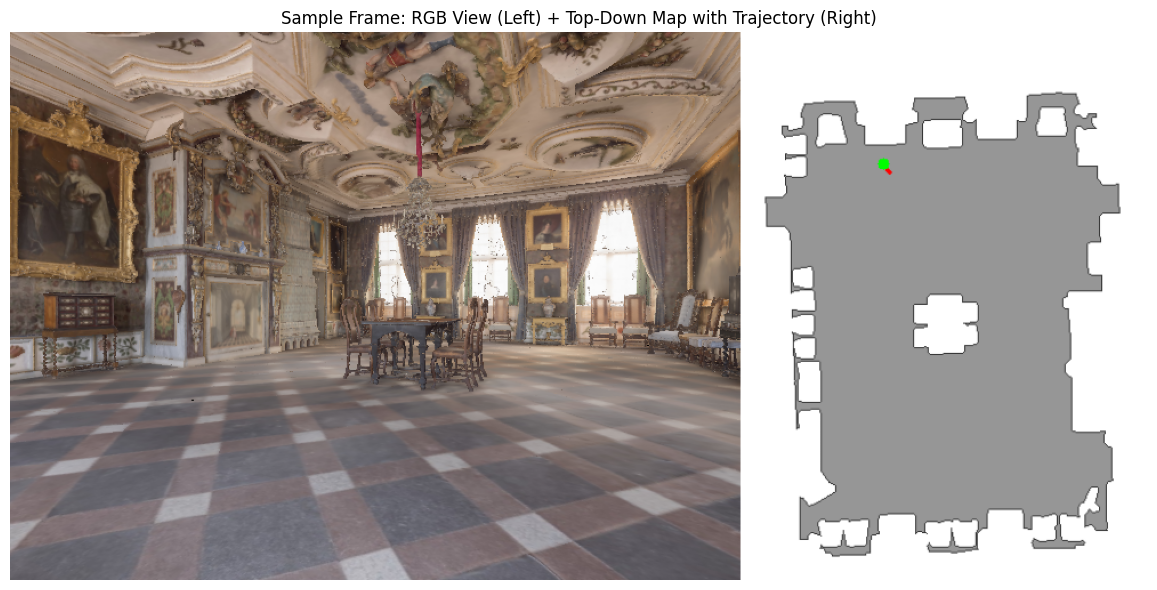

In [6]:
# Show a sample frame
sample_frame = video_frames[len(video_frames) // 2]

plt.figure(figsize=(15, 6))
plt.imshow(sample_frame)
plt.axis('off')
plt.title('Sample Frame: RGB View (Left) + Top-Down Map with Trajectory (Right)')
plt.tight_layout()
plt.show()

## Cleanup

In [7]:
# Close simulator
habitat_sim.close()
print("✓ Simulator closed.")

✓ Simulator closed.
